# Adaboost模型

# Boost

“装袋”（bagging）和“提升”（boost）是构建组合模型的两种最主要的方法，所谓的组合模型是由多个基本模型构成的模型，组合模型的预测效果往往比任意一个基本模型的效果都要好。

- 装袋：每个基本模型由从总体样本中随机抽样得到的不同数据集进行训练得到，通过重抽样得到不同训练数据集的过程称为装袋。

- 提升：每个基本模型训练时的数据集采用不同权重，针对上一个基本模型分类错误的样本增加权重，使得新的模型重点关注误分类样本

### AdaBoost

AdaBoost是AdaptiveBoost的缩写，表明该算法是具有适应性的提升算法。

算法的步骤如下：

1）给每个训练样本（x1,x2,….,xN）分配权重，初始权重$w_{1}$均为1/N。

2）针对带有权值的样本进行训练，得到模型$G_m$（初始模型为G1）。

3）计算模型$G_m$的误分率$e_m=\sum_{i=1}^Nw_iI(y_i\not= G_m(x_i))$

4）计算模型$G_m$的系数$\alpha_m=0.5\log[(1-e_m)/e_m]$

5）根据误分率e和当前权重向量$w_m$更新权重向量$w_{m+1}$。

6）计算组合模型$f(x)=\sum_{m=1}^M\alpha_mG_m(x_i)$的误分率。

7）当组合模型的误分率或迭代次数低于一定阈值，停止迭代；否则，回到步骤2）

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection  import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
    # print(data)
    return data[:,:2], data[:,-1]

In [5]:
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

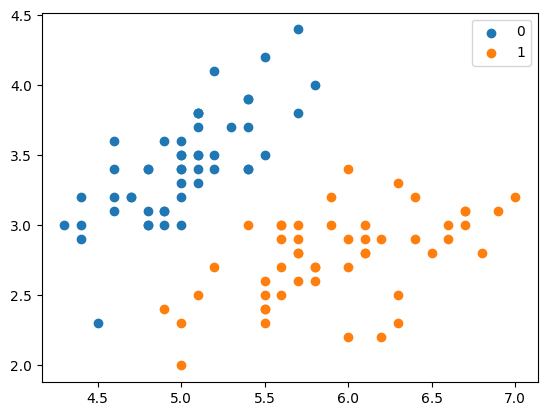

In [6]:
plt.scatter(X[:50,0],X[:50,1], label='0')
plt.scatter(X[50:,0],X[50:,1], label='1')
plt.legend()

----

### AdaBoost in Python

In [7]:
class AdaBoost:
    def __init__(self, n_estimators=50, learning_rate=1.0):
        self.clf_num = n_estimators
        self.learning_rate = learning_rate
    
    def init_args(self, datasets, labels):
        
        self.X = datasets
        self.Y = labels
        self.M, self.N = datasets.shape
        
        # 弱分类器数目和集合
        self.clf_sets = []
        
        # 初始化weights
        self.weights = [1.0/self.M]*self.M
        
        # G(x)系数 alpha
        self.alpha = []
        
    def _G(self, features, labels, weights):
        m = len(features)
        error = 100000.0 # 无穷大
        best_v = 0.0
        # 单维features
        features_min = min(features)
        features_max = max(features)
        n_step = (features_max - features_min + self.learning_rate) // self.learning_rate
        # print('n_step:{}'.format(n_step))
        direct, compare_array = None, None
        for i in range(1, int(n_step)):
            v = features_min + self.learning_rate * i
            
            if v not in features:
                # 误分类计算
                compare_array_positive = np.array([1 if features[k] > v else -1 for k in range(m)])
                weight_error_positive = sum([weights[k] for k in range(m) if compare_array_positive[k] != labels[k]])
                
                compare_array_nagetive = np.array([-1 if features[k] > v else 1 for k in range(m)])
                weight_error_nagetive = sum([weights[k] for k in range(m) if compare_array_nagetive[k] != labels[k]])

                if weight_error_positive < weight_error_nagetive:
                    weight_error = weight_error_positive
                    _compare_array = compare_array_positive
                    direct = 'positive'
                else:
                    weight_error = weight_error_nagetive
                    _compare_array = compare_array_nagetive
                    direct = 'nagetive'
                    
                # print('v:{} error:{}'.format(v, weight_error))
                if weight_error < error:
                    error = weight_error
                    compare_array = _compare_array
                    best_v = v
        return best_v, direct, error, compare_array
        
    # 计算alpha
    def _alpha(self, error):
        return 0.5 * np.log((1-error)/error)
    
    # 规范化因子
    def _Z(self, weights, a, clf):
        return sum([weights[i]*np.exp(-1*a*self.Y[i]*clf[i]) for i in range(self.M)])
        
    # 权值更新
    def _w(self, a, clf, Z):
        for i in range(self.M):
            self.weights[i] = self.weights[i]*np.exp(-1*a*self.Y[i]*clf[i])/ Z
    
    # G(x)的线性组合
    def _f(self, alpha, clf_sets):
        pass
    
    def G(self, x, v, direct):
        if direct == 'positive':
            return 1 if x > v else -1 
        else:
            return -1 if x > v else 1 
    
    def fit(self, X, y):
        self.init_args(X, y)
        
        for epoch in range(self.clf_num):
            best_clf_error, best_v, clf_result = 100000, None, None
            # 根据特征维度, 选择误差最小的
            for j in range(self.N):
                features = self.X[:, j]
                # 分类阈值，分类误差，分类结果
                v, direct, error, compare_array = self._G(features, self.Y, self.weights)
                
                if error < best_clf_error:
                    best_clf_error = error
                    best_v = v
                    final_direct = direct
                    clf_result = compare_array
                    axis = j
                    
                # print('epoch:{}/{} feature:{} error:{} v:{}'.format(epoch, self.clf_num, j, error, best_v))
                if best_clf_error == 0:
                    break
                
            # 计算G(x)系数a
            a = self._alpha(best_clf_error)
            self.alpha.append(a)
            # 记录分类器
            self.clf_sets.append((axis, best_v, final_direct))
            # 规范化因子
            Z = self._Z(self.weights, a, clf_result)
            # 权值更新
            self._w(a, clf_result, Z)
            
#             print('classifier:{}/{} error:{:.3f} v:{} direct:{} a:{:.5f}'.format(epoch+1, self.clf_num, error, best_v, final_direct, a))
#             print('weight:{}'.format(self.weights))
#             print('\n')
    
    def predict(self, feature):
        result = 0.0
        for i in range(len(self.clf_sets)):
            axis, clf_v, direct = self.clf_sets[i]
            f_input = feature[axis]
            result += self.alpha[i] * self.G(f_input, clf_v, direct)
        # sign
        return 1 if result > 0 else -1
    
    def score(self, X_test, y_test):
        right_count = 0
        for i in range(len(X_test)):
            feature = X_test[i]
            if self.predict(feature) == y_test[i]:
                right_count += 1
        
        return right_count / len(X_test)

### 例8.1

In [8]:
X = np.arange(10).reshape(10, 1)
y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])

In [9]:
clf = AdaBoost(n_estimators=3, learning_rate=0.5)
clf.fit(X, y)

In [10]:
X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [11]:
clf = AdaBoost(n_estimators=10, learning_rate=0.2)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5454545454545454

In [12]:
# 100次结果
result = []
for i in range(1, 101):
    X, y = create_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    clf = AdaBoost(n_estimators=100, learning_rate=0.2)
    clf.fit(X_train, y_train)
    r = clf.score(X_test, y_test)
    # print('{}/100 score：{}'.format(i, r))
    result.append(r)

print('average score:{:.3f}%'.format(sum(result)))

average score:65.394%


-----
# sklearn.ensemble.AdaBoostClassifier

- algorithm：这个参数只有AdaBoostClassifier有。主要原因是scikit-learn实现了两种Adaboost分类算法，SAMME和SAMME.R。两者的主要区别是弱学习器权重的度量，SAMME使用了和我们的原理篇里二元分类Adaboost算法的扩展，即用对样本集分类效果作为弱学习器权重，而SAMME.R使用了对样本集分类的预测概率大小来作为弱学习器权重。由于SAMME.R使用了概率度量的连续值，迭代一般比SAMME快，因此AdaBoostClassifier的默认算法algorithm的值也是SAMME.R。我们一般使用默认的SAMME.R就够了，但是要注意的是使用了SAMME.R， 则弱分类学习器参数base_estimator必须限制使用支持概率预测的分类器。SAMME算法则没有这个限制。

- n_estimators： AdaBoostClassifier和AdaBoostRegressor都有，就是我们的弱学习器的最大迭代次数，或者说最大的弱学习器的个数。一般来说n_estimators太小，容易欠拟合，n_estimators太大，又容易过拟合，一般选择一个适中的数值。默认是50。在实际调参的过程中，我们常常将n_estimators和下面介绍的参数learning_rate一起考虑。

-  learning_rate:  AdaBoostClassifier和AdaBoostRegressor都有，即每个弱学习器的权重缩减系数ν

- base_estimator：AdaBoostClassifier和AdaBoostRegressor都有，即我们的弱分类学习器或者弱回归学习器。理论上可以选择任何一个分类或者回归学习器，不过需要支持样本权重。我们常用的一般是CART决策树或者神经网络MLP。

In [13]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.5,algorithm='SAMME')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:514: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


0.8787878787878788

In [14]:
#clf.score(X_test, y_test)

## 任务
### 在给定数据集上分析Adaboost的性能，分析学习器的数量对集成效果的影响，进行性能可视化，给出分析结论。

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# 1. 数据准备
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
    return data[:,:2], data[:,-1]

X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

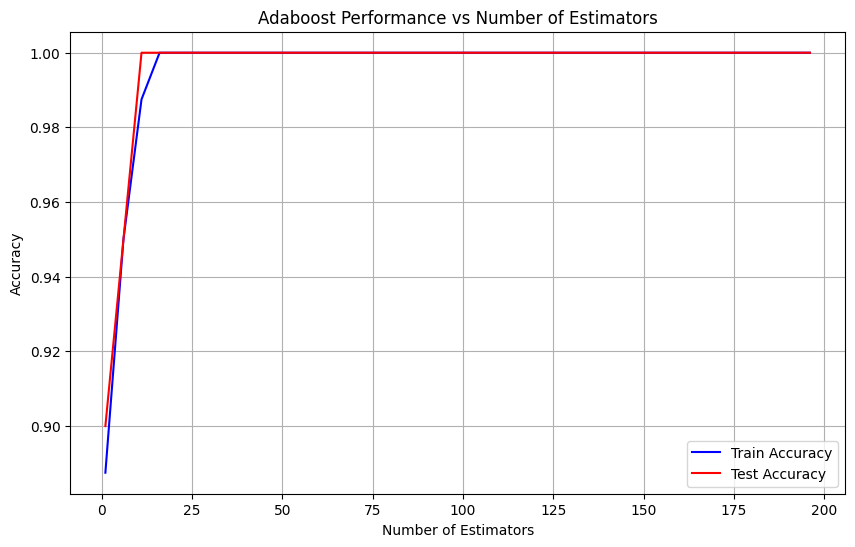

/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:514: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


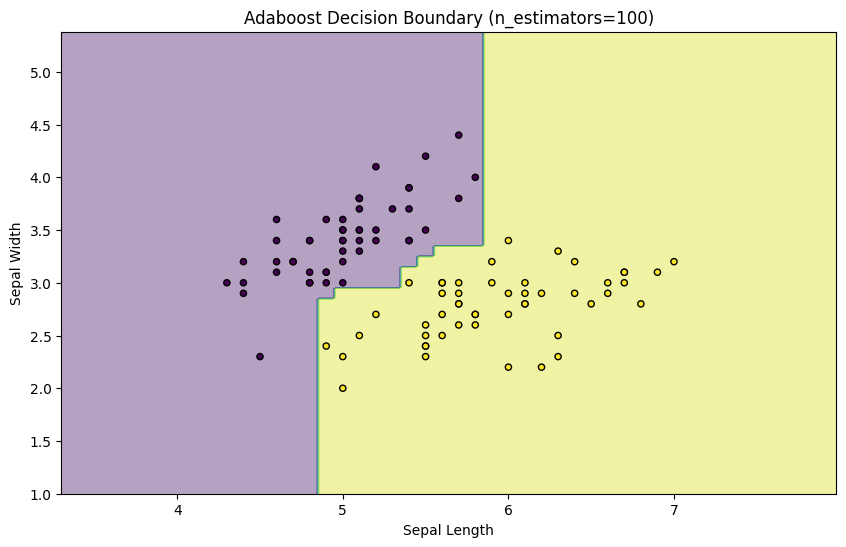

Final model test accuracy: 1.0000


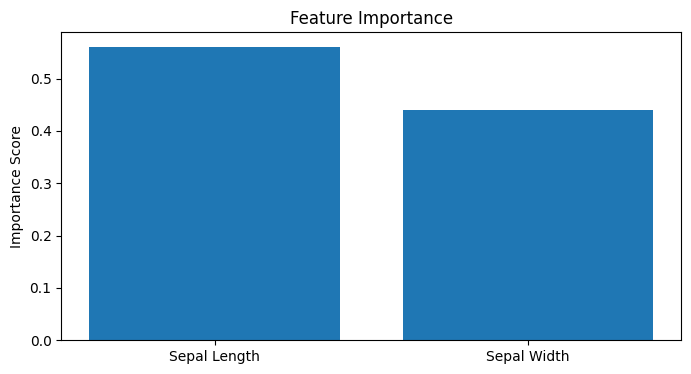

In [6]:
n_estimators_range = range(1, 201, 5)
train_scores = []
test_scores = []

for n in n_estimators_range:
    clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1),
        n_estimators=n,
        learning_rate=0.5,
        #algorithm='SAMME'
    )
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, label='Train Accuracy', color='blue')
plt.plot(n_estimators_range, test_scores, label='Test Accuracy', color='red')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Adaboost Performance vs Number of Estimators')
plt.legend()
plt.grid(True)
plt.show()

final_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.5,
    algorithm='SAMME'
)
final_clf.fit(X_train, y_train)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = final_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
plt.title('Adaboost Decision Boundary (n_estimators=100)')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.show()

print(f"Final model test accuracy: {final_clf.score(X_test, y_test):.4f}")

if hasattr(final_clf, 'feature_importances_'):
    plt.figure(figsize=(8, 4))
    plt.bar(['Sepal Length', 'Sepal Width'], final_clf.feature_importances_)
    plt.title('Feature Importance')
    plt.ylabel('Importance Score')
    plt.show()

#### 不同数量学习器对结果的影响

随着n_estimators的增加，训练准确率通常单调上升，因为更多的弱学习器可以更好地拟合训练数据。
测试准确率最初随着n_estimators的增加而提高，但达到一定数量后趋于稳定或开始波动，表明存在一个最优的n_estimators值。
过多的n_estimators可能导致过拟合，尽管Adaboost相对不容易过拟合。

#### 学习率的影响

较低的学习率(如0.1)需要更多的n_estimators来达到相同性能。
较高的学习率(如0.5或1.0)可以更快地提升性能，但也可能更早地达到性能峰值。